In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [2]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [3]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



    
if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                   txt_COVID='/home/wangchenxu/covid/Data-split/COVID/trainCT_COVID.txt',
                                   txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                                   transform=train_transformer)
    valset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                 txt_COVID='/home/wangchenxu/covid/Data-split/COVID/valCT_COVID.txt',
                                 txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/valCT_NonCOVID.txt',
                                 transform=val_transformer)
    testset = CovidCTDataset(root_dir='/home/wangchenxu/covid/Images-processed',
                                 txt_COVID='/home/wangchenxu/covid/Data-split/COVID/testCT_COVID.txt',
                                 txt_NonCOVID='/home/wangchenxu/covid/Data-split/NonCOVID/testCT_NonCOVID.txt',
                                 transform=val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


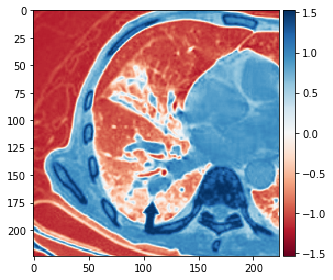

In [4]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
skimage.io.imshow(data[0,1,:,:].numpy())

In [5]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
#         data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        #mixup loss
#         loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f = open('model_result/{}.txt'.format(modelname), 'a+')
#     f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
#     f.write('\n')
#     f.close()

In [6]:
#val process is defined here

def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [7]:
#test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist
    
    # Write to tensorboard
#     writer.add_scalar('Test Accuracy', 100.0 * correct / len(test_loader.dataset), epoch)

In [8]:
### Dense169
import torchvision.models as models
model = models.densenet169(pretrained=True).cuda()
# modelname = 'Dense169'

"""load MoCo pretrained model"""
checkpoint = torch.load('save_model_dense/checkpoint_luna_covid.tar')
# # # print(checkpoint.keys())
# # # print(checkpoint['arch'])

state_dict = checkpoint['state_dict']
for key in list(state_dict.keys()):
    if 'module.encoder_q' in key:
#         print(key[17:])
        new_key = key[17:]
        state_dict[new_key] = state_dict[key]
    del state_dict[key]
for key in list(state_dict.keys()):
    if  key == 'classifier.0.weight':
        new_key = 'classifier.weight'
        state_dict[new_key] = state_dict[key]
        del state_dict[key]
    if  key == 'classifier.0.bias':
        new_key = 'classifier.bias'
        state_dict[new_key] = state_dict[key]
        del state_dict[key]
    if  key == 'classifier.2.weight' or key == 'classifier.2.bias':
        del state_dict[key]
state_dict['classifier.weight'] = state_dict['classifier.weight'][:1000,:]
state_dict['classifier.bias'] = state_dict['classifier.bias'][:1000]
model.load_state_dict(checkpoint['state_dict'])

# # # print(model)

<All keys matched successfully>

In [9]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""


# model = models.densenet169(pretrained=True).cuda()
# pretrained_net = torch.load('Self-Trans.pt')

# model.load_state_dict(pretrained_net)

# modelname = 'Dense169_ssl_luna_moco'

'Change names and locations to the Self-Trans.pt'

In [10]:
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())
total_epoch = 150

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
                                             
# scheduler = StepLR(optimizer, step_size=1)

for epoch in range(1, total_epoch+1):
    
    scheduler.step()
    
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), 'save_model_dense/covid_moco.pt')  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

#         f = open('model_result/medical_transfer/{}_{}.txt'.format(modelname,alpha_name), 'a+')
#         f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
#         epoch, r, p, F1, acc, AUC))
#         f.close()



Train Epoch: 1 [0/107 (0%)]	Train Loss: 1.789013
Train Epoch: 1 [4/107 (4%)]	Train Loss: 1.305024
Train Epoch: 1 [8/107 (7%)]	Train Loss: 0.552971
Train Epoch: 1 [12/107 (11%)]	Train Loss: 0.188670
Train Epoch: 1 [16/107 (15%)]	Train Loss: 0.195091
Train Epoch: 1 [20/107 (19%)]	Train Loss: 0.148177
Train Epoch: 1 [24/107 (22%)]	Train Loss: 0.154550
Train Epoch: 1 [28/107 (26%)]	Train Loss: 0.195373
Train Epoch: 1 [32/107 (30%)]	Train Loss: 0.136773
Train Epoch: 1 [36/107 (34%)]	Train Loss: 0.453245
Train Epoch: 1 [40/107 (37%)]	Train Loss: 0.068195
Train Epoch: 1 [44/107 (41%)]	Train Loss: 0.152751
Train Epoch: 1 [48/107 (45%)]	Train Loss: 0.194741
Train Epoch: 1 [52/107 (49%)]	Train Loss: 0.326931
Train Epoch: 1 [56/107 (52%)]	Train Loss: 0.276739
Train Epoch: 1 [60/107 (56%)]	Train Loss: 0.140563
Train Epoch: 1 [64/107 (60%)]	Train Loss: 0.175018
Train Epoch: 1 [68/107 (64%)]	Train Loss: 0.126016
Train Epoch: 1 [72/107 (67%)]	Train Loss: 0.133005
Train Epoch: 1 [76/107 (71%)]	Train L

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.13374150e-01 9.43699181e-01 8.94381225e-01 9.72586811e-01
 9.57227290e-01 7.36821413e-01 8.96167934e-01 9.87408757e-01
 4.54523236e-01 2.08751136e-03 1.90902010e-01 6.77178730e-04
 5.79581618e-01 9.97043431e-01 9.90742862e-01 6.43843770e-01
 5.28324783e-01 8.59744966e-01 4.14243303e-02 7.71848619e-01
 8.44035149e-01 9.33930039e-01 9.95114923e-01 9.99727070e-01
 7.99823165e-01 9.95372832e-01 9.99911904e-01 9.94859695e-01
 8.70765209e-01 6.26746178e-01 9.89199638e-01 8.35961699e-01
 9.58456755e-01 6.09313021e-04 2.65613460e-04 1.75833015e-03
 2.77553983e-02 9.94211257e-01 7.03330457e-01 7.39212573e-01
 7.14429200e-01 8

Train Epoch: 6 [0/107 (0%)]	Train Loss: 0.118700
Train Epoch: 6 [4/107 (4%)]	Train Loss: 0.128966
Train Epoch: 6 [8/107 (7%)]	Train Loss: 0.203262
Train Epoch: 6 [12/107 (11%)]	Train Loss: 0.326754
Train Epoch: 6 [16/107 (15%)]	Train Loss: 0.049343
Train Epoch: 6 [20/107 (19%)]	Train Loss: 0.167736
Train Epoch: 6 [24/107 (22%)]	Train Loss: 0.037380
Train Epoch: 6 [28/107 (26%)]	Train Loss: 0.075914
Train Epoch: 6 [32/107 (30%)]	Train Loss: 0.094501
Train Epoch: 6 [36/107 (34%)]	Train Loss: 0.100672
Train Epoch: 6 [40/107 (37%)]	Train Loss: 0.094503
Train Epoch: 6 [44/107 (41%)]	Train Loss: 0.161291
Train Epoch: 6 [48/107 (45%)]	Train Loss: 0.116731
Train Epoch: 6 [52/107 (49%)]	Train Loss: 0.087760
Train Epoch: 6 [56/107 (52%)]	Train Loss: 0.296684
Train Epoch: 6 [60/107 (56%)]	Train Loss: 0.238616
Train Epoch: 6 [64/107 (60%)]	Train Loss: 0.055840
Train Epoch: 6 [68/107 (64%)]	Train Loss: 0.381576
Train Epoch: 6 [72/107 (67%)]	Train Loss: 0.236655
Train Epoch: 6 [76/107 (71%)]	Train L

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.63323522e-01 8.58134866e-01 3.21878612e-01 1.09396957e-01
 3.28059524e-01 5.24132587e-02 6.17883146e-01 3.76348615e-01
 5.19584641e-02 1.25201851e-01 7.88124621e-01 2.69881785e-02
 4.96728450e-01 6.61125779e-03 1.57330170e-01 5.01763367e-04
 3.07700154e-03 6.74968004e-01 6.37439787e-02 4.24548149e-01
 5.47817469e-01 7.69863784e-01 5.76454043e-01 9.90350902e-01
 4.70117897e-01 9.84506309e-01 9.99024630e-01 5.99217117e-01
 4.64927964e-02 8.86315331e-02 4.10126150e-01 6.86569870e-01
 8.56704950e-01 2.15509417e-03 3.10315401e-03 1.67652722e-02
 1.70679390e-02 9.92803514e-01 9.30965006e-01 1.25139013e-01
 1.77606586e-02 4

Train Epoch: 11 [0/107 (0%)]	Train Loss: 0.066158
Train Epoch: 11 [4/107 (4%)]	Train Loss: 0.524973
Train Epoch: 11 [8/107 (7%)]	Train Loss: 0.064328
Train Epoch: 11 [12/107 (11%)]	Train Loss: 0.006502
Train Epoch: 11 [16/107 (15%)]	Train Loss: 0.039962
Train Epoch: 11 [20/107 (19%)]	Train Loss: 0.077863
Train Epoch: 11 [24/107 (22%)]	Train Loss: 0.033701
Train Epoch: 11 [28/107 (26%)]	Train Loss: 0.058495
Train Epoch: 11 [32/107 (30%)]	Train Loss: 0.116759
Train Epoch: 11 [36/107 (34%)]	Train Loss: 0.066881
Train Epoch: 11 [40/107 (37%)]	Train Loss: 0.007689
Train Epoch: 11 [44/107 (41%)]	Train Loss: 0.009234
Train Epoch: 11 [48/107 (45%)]	Train Loss: 0.030485
Train Epoch: 11 [52/107 (49%)]	Train Loss: 0.333780
Train Epoch: 11 [56/107 (52%)]	Train Loss: 0.131399
Train Epoch: 11 [60/107 (56%)]	Train Loss: 0.052607
Train Epoch: 11 [64/107 (60%)]	Train Loss: 0.031328
Train Epoch: 11 [68/107 (64%)]	Train Loss: 0.002138
Train Epoch: 11 [72/107 (67%)]	Train Loss: 0.131523
Train Epoch: 11 [7

Train Epoch: 13 [64/107 (60%)]	Train Loss: 0.160888
Train Epoch: 13 [68/107 (64%)]	Train Loss: 0.243686
Train Epoch: 13 [72/107 (67%)]	Train Loss: 0.029754
Train Epoch: 13 [76/107 (71%)]	Train Loss: 0.019947
Train Epoch: 13 [80/107 (75%)]	Train Loss: 0.040387
Train Epoch: 13 [84/107 (79%)]	Train Loss: 0.334986
Train Epoch: 13 [88/107 (82%)]	Train Loss: 0.046014
Train Epoch: 13 [92/107 (86%)]	Train Loss: 0.028408
Train Epoch: 13 [96/107 (90%)]	Train Loss: 0.004560
Train Epoch: 13 [100/107 (93%)]	Train Loss: 0.013149
Train Epoch: 13 [104/107 (97%)]	Train Loss: 0.007981
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.33072972e-01 7.36008048e-01 4.13638741e-01 4.84276

Train Epoch: 15 [88/107 (82%)]	Train Loss: 0.109487
Train Epoch: 15 [92/107 (86%)]	Train Loss: 0.071715
Train Epoch: 15 [96/107 (90%)]	Train Loss: 0.009508
Train Epoch: 15 [100/107 (93%)]	Train Loss: 0.028312
Train Epoch: 15 [104/107 (97%)]	Train Loss: 0.006046
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.37984523e-01 3.70616257e-01 7.22424611e-02 5.46349108e-01
 8.05215120e-01 2.66175251e-02 4.39747214e-01 5.88255644e-01
 5.89823201e-02 2.30511539e-02 8.57342243e-01 1.71533157e-03
 6.27460361e-01 2.88493605e-03 5.50406352e-02 2.77436775e-04
 5.34846913e-04 2.09559813e-01 1.45099759e-02 3.59128535e-01
 6.45081550e-02 6.84597671e-01 2.58157045e-01 9.99831080e-01

Train Epoch: 18 [0/107 (0%)]	Train Loss: 0.007258
Train Epoch: 18 [4/107 (4%)]	Train Loss: 0.006483
Train Epoch: 18 [8/107 (7%)]	Train Loss: 0.005115
Train Epoch: 18 [12/107 (11%)]	Train Loss: 0.104650
Train Epoch: 18 [16/107 (15%)]	Train Loss: 0.104201
Train Epoch: 18 [20/107 (19%)]	Train Loss: 0.057293
Train Epoch: 18 [24/107 (22%)]	Train Loss: 0.006343
Train Epoch: 18 [28/107 (26%)]	Train Loss: 0.015190
Train Epoch: 18 [32/107 (30%)]	Train Loss: 0.001130
Train Epoch: 18 [36/107 (34%)]	Train Loss: 0.022320
Train Epoch: 18 [40/107 (37%)]	Train Loss: 0.153971
Train Epoch: 18 [44/107 (41%)]	Train Loss: 0.067742
Train Epoch: 18 [48/107 (45%)]	Train Loss: 0.232953
Train Epoch: 18 [52/107 (49%)]	Train Loss: 0.027351
Train Epoch: 18 [56/107 (52%)]	Train Loss: 0.007480
Train Epoch: 18 [60/107 (56%)]	Train Loss: 0.091708
Train Epoch: 18 [64/107 (60%)]	Train Loss: 0.144689
Train Epoch: 18 [68/107 (64%)]	Train Loss: 0.034805
Train Epoch: 18 [72/107 (67%)]	Train Loss: 0.002910
Train Epoch: 18 [7

Train Epoch: 20 [28/107 (26%)]	Train Loss: 0.348677
Train Epoch: 20 [32/107 (30%)]	Train Loss: 0.252283
Train Epoch: 20 [36/107 (34%)]	Train Loss: 0.013660
Train Epoch: 20 [40/107 (37%)]	Train Loss: 0.020161
Train Epoch: 20 [44/107 (41%)]	Train Loss: 0.039929
Train Epoch: 20 [48/107 (45%)]	Train Loss: 0.007344
Train Epoch: 20 [52/107 (49%)]	Train Loss: 0.036976
Train Epoch: 20 [56/107 (52%)]	Train Loss: 0.124888
Train Epoch: 20 [60/107 (56%)]	Train Loss: 0.090638
Train Epoch: 20 [64/107 (60%)]	Train Loss: 0.159330
Train Epoch: 20 [68/107 (64%)]	Train Loss: 0.028688
Train Epoch: 20 [72/107 (67%)]	Train Loss: 0.005884
Train Epoch: 20 [76/107 (71%)]	Train Loss: 0.022015
Train Epoch: 20 [80/107 (75%)]	Train Loss: 0.021000
Train Epoch: 20 [84/107 (79%)]	Train Loss: 0.019193
Train Epoch: 20 [88/107 (82%)]	Train Loss: 0.003844
Train Epoch: 20 [92/107 (86%)]	Train Loss: 0.258113
Train Epoch: 20 [96/107 (90%)]	Train Loss: 0.012665
Train Epoch: 20 [100/107 (93%)]	Train Loss: 0.111044
Train Epoch

Train Epoch: 22 [8/107 (7%)]	Train Loss: 0.020440
Train Epoch: 22 [12/107 (11%)]	Train Loss: 0.012725
Train Epoch: 22 [16/107 (15%)]	Train Loss: 0.012420
Train Epoch: 22 [20/107 (19%)]	Train Loss: 0.002295
Train Epoch: 22 [24/107 (22%)]	Train Loss: 0.021639
Train Epoch: 22 [28/107 (26%)]	Train Loss: 0.007409
Train Epoch: 22 [32/107 (30%)]	Train Loss: 0.036948
Train Epoch: 22 [36/107 (34%)]	Train Loss: 0.000950
Train Epoch: 22 [40/107 (37%)]	Train Loss: 0.106075
Train Epoch: 22 [44/107 (41%)]	Train Loss: 0.001886
Train Epoch: 22 [48/107 (45%)]	Train Loss: 0.002836
Train Epoch: 22 [52/107 (49%)]	Train Loss: 0.105838
Train Epoch: 22 [56/107 (52%)]	Train Loss: 0.000810
Train Epoch: 22 [60/107 (56%)]	Train Loss: 0.007854
Train Epoch: 22 [64/107 (60%)]	Train Loss: 0.151654
Train Epoch: 22 [68/107 (64%)]	Train Loss: 0.623412
Train Epoch: 22 [72/107 (67%)]	Train Loss: 0.049555
Train Epoch: 22 [76/107 (71%)]	Train Loss: 0.375295
Train Epoch: 22 [80/107 (75%)]	Train Loss: 0.158526
Train Epoch: 2

Train Epoch: 24 [32/107 (30%)]	Train Loss: 0.004430
Train Epoch: 24 [36/107 (34%)]	Train Loss: 0.022136
Train Epoch: 24 [40/107 (37%)]	Train Loss: 0.200539
Train Epoch: 24 [44/107 (41%)]	Train Loss: 0.184469
Train Epoch: 24 [48/107 (45%)]	Train Loss: 0.012660
Train Epoch: 24 [52/107 (49%)]	Train Loss: 0.227211
Train Epoch: 24 [56/107 (52%)]	Train Loss: 0.010253
Train Epoch: 24 [60/107 (56%)]	Train Loss: 0.002773
Train Epoch: 24 [64/107 (60%)]	Train Loss: 0.137052
Train Epoch: 24 [68/107 (64%)]	Train Loss: 0.000942
Train Epoch: 24 [72/107 (67%)]	Train Loss: 0.007772
Train Epoch: 24 [76/107 (71%)]	Train Loss: 0.017172
Train Epoch: 24 [80/107 (75%)]	Train Loss: 0.003419
Train Epoch: 24 [84/107 (79%)]	Train Loss: 0.000407
Train Epoch: 24 [88/107 (82%)]	Train Loss: 0.014448
Train Epoch: 24 [92/107 (86%)]	Train Loss: 0.070577
Train Epoch: 24 [96/107 (90%)]	Train Loss: 0.203355
Train Epoch: 24 [100/107 (93%)]	Train Loss: 0.015577
Train Epoch: 24 [104/107 (97%)]	Train Loss: 0.080458
target [0.

Train Epoch: 26 [56/107 (52%)]	Train Loss: 0.001610
Train Epoch: 26 [60/107 (56%)]	Train Loss: 0.001317
Train Epoch: 26 [64/107 (60%)]	Train Loss: 0.170053
Train Epoch: 26 [68/107 (64%)]	Train Loss: 0.003249
Train Epoch: 26 [72/107 (67%)]	Train Loss: 0.218403
Train Epoch: 26 [76/107 (71%)]	Train Loss: 0.279574
Train Epoch: 26 [80/107 (75%)]	Train Loss: 0.189622
Train Epoch: 26 [84/107 (79%)]	Train Loss: 0.036532
Train Epoch: 26 [88/107 (82%)]	Train Loss: 0.009703
Train Epoch: 26 [92/107 (86%)]	Train Loss: 0.006016
Train Epoch: 26 [96/107 (90%)]	Train Loss: 0.011533
Train Epoch: 26 [100/107 (93%)]	Train Loss: 0.022699
Train Epoch: 26 [104/107 (97%)]	Train Loss: 0.001046
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 28 [80/107 (75%)]	Train Loss: 0.053168
Train Epoch: 28 [84/107 (79%)]	Train Loss: 0.011824
Train Epoch: 28 [88/107 (82%)]	Train Loss: 0.047445
Train Epoch: 28 [92/107 (86%)]	Train Loss: 0.000531
Train Epoch: 28 [96/107 (90%)]	Train Loss: 0.004035
Train Epoch: 28 [100/107 (93%)]	Train Loss: 0.006822
Train Epoch: 28 [104/107 (97%)]	Train Loss: 0.000895
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.80921185e-01 9.96895194e-01 3.33607882e-01 7.80012906e-01
 3.02973330e-01 3.90047915e-02 9.84483659e-01 8.22245538e-01
 2.69664656e-02 1.24244913e-01 5.27489245e-01 8.24998785e-03
 1.69626221e-01 3.09391439e-01 6.51654124e-01 1.28494063e-03
 1.76823552e-04 9

Train Epoch: 30 [104/107 (97%)]	Train Loss: 0.048755
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.51580751e-01 8.46894860e-01 2.68035680e-02 9.96955037e-01
 9.70647871e-01 1.01296827e-01 5.55986881e-01 9.83349919e-01
 7.53835142e-01 6.23065710e-01 9.96320128e-01 3.78445238e-02
 9.92200792e-01 2.51450296e-03 6.25940859e-01 3.11734475e-05
 1.78100003e-04 9.92869794e-01 4.35482174e-01 4.35108542e-01
 7.36606658e-01 9.99808252e-01 9.99999642e-01 9.99999523e-01
 9.92416859e-01 9.99988556e-01 9.99996901e-01 1.23218834e-01
 8.94585624e-03 3.72531377e-02 1.09986048e-02 2.31406853e-01
 5.74718416e-01 5.95939578e-04 1.29076780e-03 3.69231813e-02
 4.33316559e-01 9.9951148

Train Epoch: 32 [48/107 (45%)]	Train Loss: 0.411618
Train Epoch: 32 [52/107 (49%)]	Train Loss: 0.076133
Train Epoch: 32 [56/107 (52%)]	Train Loss: 0.009506
Train Epoch: 32 [60/107 (56%)]	Train Loss: 0.002590
Train Epoch: 32 [64/107 (60%)]	Train Loss: 0.153629
Train Epoch: 32 [68/107 (64%)]	Train Loss: 0.092585
Train Epoch: 32 [72/107 (67%)]	Train Loss: 0.029680
Train Epoch: 32 [76/107 (71%)]	Train Loss: 0.029886
Train Epoch: 32 [80/107 (75%)]	Train Loss: 0.015673
Train Epoch: 32 [84/107 (79%)]	Train Loss: 0.003810
Train Epoch: 32 [88/107 (82%)]	Train Loss: 0.012160
Train Epoch: 32 [92/107 (86%)]	Train Loss: 0.001812
Train Epoch: 32 [96/107 (90%)]	Train Loss: 0.004232
Train Epoch: 32 [100/107 (93%)]	Train Loss: 0.007155
Train Epoch: 32 [104/107 (97%)]	Train Loss: 0.000885
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 34 [72/107 (67%)]	Train Loss: 0.322655
Train Epoch: 34 [76/107 (71%)]	Train Loss: 0.028245
Train Epoch: 34 [80/107 (75%)]	Train Loss: 0.009318
Train Epoch: 34 [84/107 (79%)]	Train Loss: 0.101260
Train Epoch: 34 [88/107 (82%)]	Train Loss: 0.001428
Train Epoch: 34 [92/107 (86%)]	Train Loss: 0.002358
Train Epoch: 34 [96/107 (90%)]	Train Loss: 0.000395
Train Epoch: 34 [100/107 (93%)]	Train Loss: 0.002136
Train Epoch: 34 [104/107 (97%)]	Train Loss: 0.217984
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.54003257e-02 8.22898030e-01 1.36940286e-01 3.23111236e-01
 7.67449439e-02 4.49921861e-02 9.32862461e-01 3.47217709e-01
 3.04716919e-02 8.23761448e-02 4.89

Train Epoch: 36 [96/107 (90%)]	Train Loss: 0.001035
Train Epoch: 36 [100/107 (93%)]	Train Loss: 0.002845
Train Epoch: 36 [104/107 (97%)]	Train Loss: 0.034010
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.11058706e-02 8.30126882e-01 2.64052749e-02 9.86184776e-01
 9.89745438e-01 7.16468394e-02 6.35308206e-01 9.94314253e-01
 4.20402065e-02 3.26848209e-01 9.81158078e-01 3.83910626e-01
 9.69247818e-01 6.03463151e-04 4.44901772e-02 3.66675016e-03
 2.91951397e-03 9.99869943e-01 1.64852202e-01 2.51065284e-01
 2.14839607e-01 9.99953628e-01 9.99997616e-01 9.99998927e-01
 9.99999046e-01 9.99982953e-01 9.99998927e-01 1.55138774e-02
 2.12157905e-01 4.51635234e-02 9.24967885e

Train Epoch: 39 [0/107 (0%)]	Train Loss: 0.013872
Train Epoch: 39 [4/107 (4%)]	Train Loss: 0.003565
Train Epoch: 39 [8/107 (7%)]	Train Loss: 0.018991
Train Epoch: 39 [12/107 (11%)]	Train Loss: 0.001741
Train Epoch: 39 [16/107 (15%)]	Train Loss: 0.005912
Train Epoch: 39 [20/107 (19%)]	Train Loss: 0.002335
Train Epoch: 39 [24/107 (22%)]	Train Loss: 0.005194
Train Epoch: 39 [28/107 (26%)]	Train Loss: 0.000207
Train Epoch: 39 [32/107 (30%)]	Train Loss: 0.002629
Train Epoch: 39 [36/107 (34%)]	Train Loss: 0.001138
Train Epoch: 39 [40/107 (37%)]	Train Loss: 0.001811
Train Epoch: 39 [44/107 (41%)]	Train Loss: 0.042928
Train Epoch: 39 [48/107 (45%)]	Train Loss: 0.000675
Train Epoch: 39 [52/107 (49%)]	Train Loss: 0.000784
Train Epoch: 39 [56/107 (52%)]	Train Loss: 0.132107
Train Epoch: 39 [60/107 (56%)]	Train Loss: 0.002784
Train Epoch: 39 [64/107 (60%)]	Train Loss: 0.001049
Train Epoch: 39 [68/107 (64%)]	Train Loss: 0.075314
Train Epoch: 39 [72/107 (67%)]	Train Loss: 0.012709
Train Epoch: 39 [7


 The epoch is 40, average recall: 0.8793, average precision: 0.7183,average F1: 0.7907, average accuracy: 0.7712, average AUC: 0.8468
Train Epoch: 41 [0/107 (0%)]	Train Loss: 0.001209
Train Epoch: 41 [4/107 (4%)]	Train Loss: 0.000480
Train Epoch: 41 [8/107 (7%)]	Train Loss: 0.000183
Train Epoch: 41 [12/107 (11%)]	Train Loss: 0.011651
Train Epoch: 41 [16/107 (15%)]	Train Loss: 0.025811
Train Epoch: 41 [20/107 (19%)]	Train Loss: 0.003802
Train Epoch: 41 [24/107 (22%)]	Train Loss: 0.000681
Train Epoch: 41 [28/107 (26%)]	Train Loss: 0.003757
Train Epoch: 41 [32/107 (30%)]	Train Loss: 0.047946
Train Epoch: 41 [36/107 (34%)]	Train Loss: 0.002302
Train Epoch: 41 [40/107 (37%)]	Train Loss: 0.001151
Train Epoch: 41 [44/107 (41%)]	Train Loss: 0.000552
Train Epoch: 41 [48/107 (45%)]	Train Loss: 0.013029
Train Epoch: 41 [52/107 (49%)]	Train Loss: 0.000815
Train Epoch: 41 [56/107 (52%)]	Train Loss: 0.043921
Train Epoch: 41 [60/107 (56%)]	Train Loss: 0.035106
Train Epoch: 41 [64/107 (60%)]	Train Lo

Train Epoch: 43 [16/107 (15%)]	Train Loss: 0.030031
Train Epoch: 43 [20/107 (19%)]	Train Loss: 0.009928
Train Epoch: 43 [24/107 (22%)]	Train Loss: 0.002523
Train Epoch: 43 [28/107 (26%)]	Train Loss: 0.122098
Train Epoch: 43 [32/107 (30%)]	Train Loss: 0.011307
Train Epoch: 43 [36/107 (34%)]	Train Loss: 0.036848
Train Epoch: 43 [40/107 (37%)]	Train Loss: 0.007253
Train Epoch: 43 [44/107 (41%)]	Train Loss: 0.002220
Train Epoch: 43 [48/107 (45%)]	Train Loss: 0.000169
Train Epoch: 43 [52/107 (49%)]	Train Loss: 0.000121
Train Epoch: 43 [56/107 (52%)]	Train Loss: 0.000064
Train Epoch: 43 [60/107 (56%)]	Train Loss: 0.001893
Train Epoch: 43 [64/107 (60%)]	Train Loss: 0.019618
Train Epoch: 43 [68/107 (64%)]	Train Loss: 0.000179
Train Epoch: 43 [72/107 (67%)]	Train Loss: 0.000510
Train Epoch: 43 [76/107 (71%)]	Train Loss: 0.008192
Train Epoch: 43 [80/107 (75%)]	Train Loss: 0.001756
Train Epoch: 43 [84/107 (79%)]	Train Loss: 0.004347
Train Epoch: 43 [88/107 (82%)]	Train Loss: 0.000033
Train Epoch:

Train Epoch: 45 [40/107 (37%)]	Train Loss: 0.009162
Train Epoch: 45 [44/107 (41%)]	Train Loss: 0.028504
Train Epoch: 45 [48/107 (45%)]	Train Loss: 0.001040
Train Epoch: 45 [52/107 (49%)]	Train Loss: 0.001301
Train Epoch: 45 [56/107 (52%)]	Train Loss: 0.000357
Train Epoch: 45 [60/107 (56%)]	Train Loss: 0.016489
Train Epoch: 45 [64/107 (60%)]	Train Loss: 0.006873
Train Epoch: 45 [68/107 (64%)]	Train Loss: 0.008691
Train Epoch: 45 [72/107 (67%)]	Train Loss: 0.007335
Train Epoch: 45 [76/107 (71%)]	Train Loss: 0.086061
Train Epoch: 45 [80/107 (75%)]	Train Loss: 0.007728
Train Epoch: 45 [84/107 (79%)]	Train Loss: 0.040782
Train Epoch: 45 [88/107 (82%)]	Train Loss: 0.003310
Train Epoch: 45 [92/107 (86%)]	Train Loss: 0.007375
Train Epoch: 45 [96/107 (90%)]	Train Loss: 0.000293
Train Epoch: 45 [100/107 (93%)]	Train Loss: 0.014356
Train Epoch: 45 [104/107 (97%)]	Train Loss: 0.000471
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Train Epoch: 47 [64/107 (60%)]	Train Loss: 0.000410
Train Epoch: 47 [68/107 (64%)]	Train Loss: 0.000193
Train Epoch: 47 [72/107 (67%)]	Train Loss: 0.016477
Train Epoch: 47 [76/107 (71%)]	Train Loss: 0.010394
Train Epoch: 47 [80/107 (75%)]	Train Loss: 0.000106
Train Epoch: 47 [84/107 (79%)]	Train Loss: 0.169617
Train Epoch: 47 [88/107 (82%)]	Train Loss: 0.000153
Train Epoch: 47 [92/107 (86%)]	Train Loss: 0.000328
Train Epoch: 47 [96/107 (90%)]	Train Loss: 0.004772
Train Epoch: 47 [100/107 (93%)]	Train Loss: 0.076225
Train Epoch: 47 [104/107 (97%)]	Train Loss: 0.008280
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.82385787e-01 9.98977780e-01 6.67193711e-01 9.02640

Train Epoch: 49 [88/107 (82%)]	Train Loss: 0.001031
Train Epoch: 49 [92/107 (86%)]	Train Loss: 0.013512
Train Epoch: 49 [96/107 (90%)]	Train Loss: 0.002110
Train Epoch: 49 [100/107 (93%)]	Train Loss: 0.001400
Train Epoch: 49 [104/107 (97%)]	Train Loss: 0.000266
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.80238961e-02 9.91440773e-01 2.14828432e-01 2.65883446e-01
 1.01382956e-01 6.19696267e-02 9.24336433e-01 7.93799698e-01
 1.13600999e-01 4.10441123e-03 2.48921007e-01 2.79668951e-04
 3.00386608e-01 4.72019456e-04 8.34066793e-02 2.51160800e-05
 2.40728610e-07 4.45663124e-01 5.04709743e-02 1.13978244e-01
 1.82971939e-01 8.79403889e-01 9.95637476e-01 9.99673486e-01

Train Epoch: 51 [32/107 (30%)]	Train Loss: 0.000917
Train Epoch: 51 [36/107 (34%)]	Train Loss: 0.000320
Train Epoch: 51 [40/107 (37%)]	Train Loss: 0.006185
Train Epoch: 51 [44/107 (41%)]	Train Loss: 0.001016
Train Epoch: 51 [48/107 (45%)]	Train Loss: 0.008625
Train Epoch: 51 [52/107 (49%)]	Train Loss: 0.006107
Train Epoch: 51 [56/107 (52%)]	Train Loss: 0.003776
Train Epoch: 51 [60/107 (56%)]	Train Loss: 0.002312
Train Epoch: 51 [64/107 (60%)]	Train Loss: 0.000315
Train Epoch: 51 [68/107 (64%)]	Train Loss: 0.000121
Train Epoch: 51 [72/107 (67%)]	Train Loss: 0.001217
Train Epoch: 51 [76/107 (71%)]	Train Loss: 0.027690
Train Epoch: 51 [80/107 (75%)]	Train Loss: 0.000340
Train Epoch: 51 [84/107 (79%)]	Train Loss: 0.006998
Train Epoch: 51 [88/107 (82%)]	Train Loss: 0.001140
Train Epoch: 51 [92/107 (86%)]	Train Loss: 0.000029
Train Epoch: 51 [96/107 (90%)]	Train Loss: 0.002225
Train Epoch: 51 [100/107 (93%)]	Train Loss: 0.000026
Train Epoch: 51 [104/107 (97%)]	Train Loss: 0.004195
target [0.

Train Epoch: 53 [56/107 (52%)]	Train Loss: 0.006742
Train Epoch: 53 [60/107 (56%)]	Train Loss: 0.000046
Train Epoch: 53 [64/107 (60%)]	Train Loss: 0.001654
Train Epoch: 53 [68/107 (64%)]	Train Loss: 0.023890
Train Epoch: 53 [72/107 (67%)]	Train Loss: 0.024965
Train Epoch: 53 [76/107 (71%)]	Train Loss: 0.000023
Train Epoch: 53 [80/107 (75%)]	Train Loss: 0.000165
Train Epoch: 53 [84/107 (79%)]	Train Loss: 0.015062
Train Epoch: 53 [88/107 (82%)]	Train Loss: 0.000091
Train Epoch: 53 [92/107 (86%)]	Train Loss: 0.000161
Train Epoch: 53 [96/107 (90%)]	Train Loss: 0.000087
Train Epoch: 53 [100/107 (93%)]	Train Loss: 0.000628
Train Epoch: 53 [104/107 (97%)]	Train Loss: 0.005221
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 55 [80/107 (75%)]	Train Loss: 0.000119
Train Epoch: 55 [84/107 (79%)]	Train Loss: 0.003724
Train Epoch: 55 [88/107 (82%)]	Train Loss: 0.008806
Train Epoch: 55 [92/107 (86%)]	Train Loss: 0.001727
Train Epoch: 55 [96/107 (90%)]	Train Loss: 0.011375
Train Epoch: 55 [100/107 (93%)]	Train Loss: 0.008523
Train Epoch: 55 [104/107 (97%)]	Train Loss: 0.009485
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.83475146e-02 1.16205728e-02 7.85253826e-04 8.64036456e-02
 9.79632065e-02 9.58194211e-03 2.94117630e-03 2.09330693e-01
 4.72367108e-02 5.78286536e-02 8.20702195e-01 4.87105502e-03
 5.93633175e-01 1.07802572e-02 1.55135319e-01 4.16469033e-04
 6.39601058e-05 1

Train Epoch: 57 [104/107 (97%)]	Train Loss: 0.002039
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.26128197e-02 2.14227870e-01 9.13451705e-03 1.94171835e-02
 4.96947905e-03 1.25750457e-03 1.78988911e-02 1.20033072e-02
 4.03796416e-03 6.36320710e-02 7.05148280e-01 1.36246602e-03
 8.16440105e-01 8.02878814e-04 4.74279793e-03 1.04169585e-05
 2.52309360e-06 2.35297848e-02 1.22171408e-02 4.40474078e-02
 7.02616051e-02 4.08780903e-01 9.99951601e-01 9.99867916e-01
 4.75246042e-01 9.99903679e-01 9.99690890e-01 1.49917603e-02
 1.90887377e-02 7.87208555e-04 5.64826420e-04 1.57959037e-03
 1.91280991e-01 3.38126338e-05 1.25181441e-05 2.50866360e-05
 4.75566689e-04 1.9440770

Train Epoch: 60 [0/107 (0%)]	Train Loss: 0.002111
Train Epoch: 60 [4/107 (4%)]	Train Loss: 0.000145
Train Epoch: 60 [8/107 (7%)]	Train Loss: 0.002158
Train Epoch: 60 [12/107 (11%)]	Train Loss: 0.166033
Train Epoch: 60 [16/107 (15%)]	Train Loss: 0.022700
Train Epoch: 60 [20/107 (19%)]	Train Loss: 0.007727
Train Epoch: 60 [24/107 (22%)]	Train Loss: 0.001773
Train Epoch: 60 [28/107 (26%)]	Train Loss: 0.000399
Train Epoch: 60 [32/107 (30%)]	Train Loss: 0.003711
Train Epoch: 60 [36/107 (34%)]	Train Loss: 0.000167
Train Epoch: 60 [40/107 (37%)]	Train Loss: 0.000135
Train Epoch: 60 [44/107 (41%)]	Train Loss: 0.003444
Train Epoch: 60 [48/107 (45%)]	Train Loss: 0.000059
Train Epoch: 60 [52/107 (49%)]	Train Loss: 0.001772
Train Epoch: 60 [56/107 (52%)]	Train Loss: 0.001245
Train Epoch: 60 [60/107 (56%)]	Train Loss: 0.000691
Train Epoch: 60 [64/107 (60%)]	Train Loss: 0.001401
Train Epoch: 60 [68/107 (64%)]	Train Loss: 0.006624
Train Epoch: 60 [72/107 (67%)]	Train Loss: 0.006125
Train Epoch: 60 [7

Train Epoch: 62 [0/107 (0%)]	Train Loss: 0.002204
Train Epoch: 62 [4/107 (4%)]	Train Loss: 0.003195
Train Epoch: 62 [8/107 (7%)]	Train Loss: 0.000225
Train Epoch: 62 [12/107 (11%)]	Train Loss: 0.005966
Train Epoch: 62 [16/107 (15%)]	Train Loss: 0.015066
Train Epoch: 62 [20/107 (19%)]	Train Loss: 0.001358
Train Epoch: 62 [24/107 (22%)]	Train Loss: 0.008999
Train Epoch: 62 [28/107 (26%)]	Train Loss: 0.000323
Train Epoch: 62 [32/107 (30%)]	Train Loss: 0.003182
Train Epoch: 62 [36/107 (34%)]	Train Loss: 0.000416
Train Epoch: 62 [40/107 (37%)]	Train Loss: 0.000058
Train Epoch: 62 [44/107 (41%)]	Train Loss: 0.001835
Train Epoch: 62 [48/107 (45%)]	Train Loss: 0.003801
Train Epoch: 62 [52/107 (49%)]	Train Loss: 0.000366
Train Epoch: 62 [56/107 (52%)]	Train Loss: 0.011252
Train Epoch: 62 [60/107 (56%)]	Train Loss: 0.000162
Train Epoch: 62 [64/107 (60%)]	Train Loss: 0.068225
Train Epoch: 62 [68/107 (64%)]	Train Loss: 0.000161
Train Epoch: 62 [72/107 (67%)]	Train Loss: 0.000027
Train Epoch: 62 [7

Train Epoch: 64 [28/107 (26%)]	Train Loss: 0.000094
Train Epoch: 64 [32/107 (30%)]	Train Loss: 0.000699
Train Epoch: 64 [36/107 (34%)]	Train Loss: 0.002063
Train Epoch: 64 [40/107 (37%)]	Train Loss: 0.000079
Train Epoch: 64 [44/107 (41%)]	Train Loss: 0.011213
Train Epoch: 64 [48/107 (45%)]	Train Loss: 0.000041
Train Epoch: 64 [52/107 (49%)]	Train Loss: 0.000015
Train Epoch: 64 [56/107 (52%)]	Train Loss: 0.016225
Train Epoch: 64 [60/107 (56%)]	Train Loss: 0.000044
Train Epoch: 64 [64/107 (60%)]	Train Loss: 0.000127
Train Epoch: 64 [68/107 (64%)]	Train Loss: 0.000196
Train Epoch: 64 [72/107 (67%)]	Train Loss: 0.000478
Train Epoch: 64 [76/107 (71%)]	Train Loss: 0.000164
Train Epoch: 64 [80/107 (75%)]	Train Loss: 0.000118
Train Epoch: 64 [84/107 (79%)]	Train Loss: 0.000228
Train Epoch: 64 [88/107 (82%)]	Train Loss: 0.000139
Train Epoch: 64 [92/107 (86%)]	Train Loss: 0.001600
Train Epoch: 64 [96/107 (90%)]	Train Loss: 0.000144
Train Epoch: 64 [100/107 (93%)]	Train Loss: 0.003284
Train Epoch

Train Epoch: 66 [52/107 (49%)]	Train Loss: 0.000211
Train Epoch: 66 [56/107 (52%)]	Train Loss: 0.000079
Train Epoch: 66 [60/107 (56%)]	Train Loss: 0.001281
Train Epoch: 66 [64/107 (60%)]	Train Loss: 0.008267
Train Epoch: 66 [68/107 (64%)]	Train Loss: 0.004952
Train Epoch: 66 [72/107 (67%)]	Train Loss: 0.000337
Train Epoch: 66 [76/107 (71%)]	Train Loss: 0.000051
Train Epoch: 66 [80/107 (75%)]	Train Loss: 0.000327
Train Epoch: 66 [84/107 (79%)]	Train Loss: 0.001742
Train Epoch: 66 [88/107 (82%)]	Train Loss: 0.001397
Train Epoch: 66 [92/107 (86%)]	Train Loss: 0.000603
Train Epoch: 66 [96/107 (90%)]	Train Loss: 0.000242
Train Epoch: 66 [100/107 (93%)]	Train Loss: 0.000137
Train Epoch: 66 [104/107 (97%)]	Train Loss: 0.000586
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 68 [76/107 (71%)]	Train Loss: 0.000158
Train Epoch: 68 [80/107 (75%)]	Train Loss: 0.000377
Train Epoch: 68 [84/107 (79%)]	Train Loss: 0.000127
Train Epoch: 68 [88/107 (82%)]	Train Loss: 0.000239
Train Epoch: 68 [92/107 (86%)]	Train Loss: 0.020467
Train Epoch: 68 [96/107 (90%)]	Train Loss: 0.000400
Train Epoch: 68 [100/107 (93%)]	Train Loss: 0.000198
Train Epoch: 68 [104/107 (97%)]	Train Loss: 0.001589
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.27858126e-03 9.84577000e-01 2.65307147e-02 4.92143482e-02
 2.71317945e-03 4.24605270e-04 7.50592589e-01 9.76406690e-03
 5.90742857e-04 2.19061859e-02 6.40252829e-01 1.20472454e-04
 3.09144467e-01 9.89794382

Train Epoch: 70 [100/107 (93%)]	Train Loss: 0.011461
Train Epoch: 70 [104/107 (97%)]	Train Loss: 0.000609
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.14195438e-02 9.89497781e-01 1.76030155e-02 8.48495886e-02
 3.57571989e-02 1.47444452e-03 8.07352662e-01 6.09284118e-02
 1.33778085e-03 1.49728730e-02 3.65622997e-01 1.23120422e-04
 3.11769754e-01 3.26541183e-03 3.38692917e-03 3.75963391e-05
 1.23849695e-05 4.82237101e-01 1.36709912e-03 1.38634127e-02
 1.56341698e-02 5.81222415e-01 9.89635766e-01 9.99651194e-01
 2.62223810e-01 9.43322420e-01 9.88630652e-01 1.67492568e-03
 9.79851652e-03 1.12575176e-03 3.31727136e-03 5.11536421e-03
 5.88530660e-01 1.29922613e-04 1.

Train Epoch: 72 [44/107 (41%)]	Train Loss: 0.001897
Train Epoch: 72 [48/107 (45%)]	Train Loss: 0.001081
Train Epoch: 72 [52/107 (49%)]	Train Loss: 0.000382
Train Epoch: 72 [56/107 (52%)]	Train Loss: 0.000035
Train Epoch: 72 [60/107 (56%)]	Train Loss: 0.000040
Train Epoch: 72 [64/107 (60%)]	Train Loss: 0.000131
Train Epoch: 72 [68/107 (64%)]	Train Loss: 0.001171
Train Epoch: 72 [72/107 (67%)]	Train Loss: 0.000193
Train Epoch: 72 [76/107 (71%)]	Train Loss: 0.000373
Train Epoch: 72 [80/107 (75%)]	Train Loss: 0.002422
Train Epoch: 72 [84/107 (79%)]	Train Loss: 0.000199
Train Epoch: 72 [88/107 (82%)]	Train Loss: 0.000883
Train Epoch: 72 [92/107 (86%)]	Train Loss: 0.000432
Train Epoch: 72 [96/107 (90%)]	Train Loss: 0.000218
Train Epoch: 72 [100/107 (93%)]	Train Loss: 0.001613
Train Epoch: 72 [104/107 (97%)]	Train Loss: 0.001028
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 

Train Epoch: 74 [68/107 (64%)]	Train Loss: 0.001181
Train Epoch: 74 [72/107 (67%)]	Train Loss: 0.000440
Train Epoch: 74 [76/107 (71%)]	Train Loss: 0.000442
Train Epoch: 74 [80/107 (75%)]	Train Loss: 0.000185
Train Epoch: 74 [84/107 (79%)]	Train Loss: 0.003100
Train Epoch: 74 [88/107 (82%)]	Train Loss: 0.174239
Train Epoch: 74 [92/107 (86%)]	Train Loss: 0.004131
Train Epoch: 74 [96/107 (90%)]	Train Loss: 0.000312
Train Epoch: 74 [100/107 (93%)]	Train Loss: 0.003249
Train Epoch: 74 [104/107 (97%)]	Train Loss: 0.000718
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.52945610e-04 9.57519293e-01 1.14566851e-02 3.29319499e-02
 2.25398014e-03 5.52040117e-04 7.42643476e-0

Train Epoch: 76 [92/107 (86%)]	Train Loss: 0.000144
Train Epoch: 76 [96/107 (90%)]	Train Loss: 0.000650
Train Epoch: 76 [100/107 (93%)]	Train Loss: 0.001032
Train Epoch: 76 [104/107 (97%)]	Train Loss: 0.000016
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.77209687e-02 9.98102844e-01 3.31611112e-02 3.05555731e-01
 2.99342889e-02 2.87140277e-03 9.04032886e-01 1.10514663e-01
 9.38218646e-03 2.92182025e-02 4.31466401e-01 8.98992439e-05
 3.89647871e-01 7.07377912e-03 3.75367738e-02 2.96870385e-05
 6.82498376e-06 7.49856532e-01 2.97287037e-03 2.69657727e-02
 1.57457799e-01 9.66032624e-01 9.99814570e-01 9.99975085e-01
 7.19843507e-01 9.99535561e-01 9.99946713e-01 2.448

Train Epoch: 79 [0/107 (0%)]	Train Loss: 0.000679
Train Epoch: 79 [4/107 (4%)]	Train Loss: 0.000096
Train Epoch: 79 [8/107 (7%)]	Train Loss: 0.001202
Train Epoch: 79 [12/107 (11%)]	Train Loss: 0.000012
Train Epoch: 79 [16/107 (15%)]	Train Loss: 0.006083
Train Epoch: 79 [20/107 (19%)]	Train Loss: 0.000166
Train Epoch: 79 [24/107 (22%)]	Train Loss: 0.000364
Train Epoch: 79 [28/107 (26%)]	Train Loss: 0.000119
Train Epoch: 79 [32/107 (30%)]	Train Loss: 0.008773
Train Epoch: 79 [36/107 (34%)]	Train Loss: 0.000152
Train Epoch: 79 [40/107 (37%)]	Train Loss: 0.000492
Train Epoch: 79 [44/107 (41%)]	Train Loss: 0.000012
Train Epoch: 79 [48/107 (45%)]	Train Loss: 0.000070
Train Epoch: 79 [52/107 (49%)]	Train Loss: 0.000123
Train Epoch: 79 [56/107 (52%)]	Train Loss: 0.001016
Train Epoch: 79 [60/107 (56%)]	Train Loss: 0.000068
Train Epoch: 79 [64/107 (60%)]	Train Loss: 0.000417
Train Epoch: 79 [68/107 (64%)]	Train Loss: 0.000261
Train Epoch: 79 [72/107 (67%)]	Train Loss: 0.000227
Train Epoch: 79 [7


 The epoch is 80, average recall: 0.8621, average precision: 0.7353,average F1: 0.7937, average accuracy: 0.7797, average AUC: 0.8638
Train Epoch: 81 [0/107 (0%)]	Train Loss: 0.000029
Train Epoch: 81 [4/107 (4%)]	Train Loss: 0.000011
Train Epoch: 81 [8/107 (7%)]	Train Loss: 0.000092
Train Epoch: 81 [12/107 (11%)]	Train Loss: 0.000322
Train Epoch: 81 [16/107 (15%)]	Train Loss: 0.000225
Train Epoch: 81 [20/107 (19%)]	Train Loss: 0.000688
Train Epoch: 81 [24/107 (22%)]	Train Loss: 0.000056
Train Epoch: 81 [28/107 (26%)]	Train Loss: 0.000123
Train Epoch: 81 [32/107 (30%)]	Train Loss: 0.000041
Train Epoch: 81 [36/107 (34%)]	Train Loss: 0.000377
Train Epoch: 81 [40/107 (37%)]	Train Loss: 0.000017
Train Epoch: 81 [44/107 (41%)]	Train Loss: 0.000608
Train Epoch: 81 [48/107 (45%)]	Train Loss: 0.000097
Train Epoch: 81 [52/107 (49%)]	Train Loss: 0.000016
Train Epoch: 81 [56/107 (52%)]	Train Loss: 0.000052
Train Epoch: 81 [60/107 (56%)]	Train Loss: 0.000268
Train Epoch: 81 [64/107 (60%)]	Train Lo

Train Epoch: 83 [16/107 (15%)]	Train Loss: 0.000007
Train Epoch: 83 [20/107 (19%)]	Train Loss: 0.001595
Train Epoch: 83 [24/107 (22%)]	Train Loss: 0.000088
Train Epoch: 83 [28/107 (26%)]	Train Loss: 0.000136
Train Epoch: 83 [32/107 (30%)]	Train Loss: 0.005706
Train Epoch: 83 [36/107 (34%)]	Train Loss: 0.000461
Train Epoch: 83 [40/107 (37%)]	Train Loss: 0.000041
Train Epoch: 83 [44/107 (41%)]	Train Loss: 0.000357
Train Epoch: 83 [48/107 (45%)]	Train Loss: 0.001141
Train Epoch: 83 [52/107 (49%)]	Train Loss: 0.000519
Train Epoch: 83 [56/107 (52%)]	Train Loss: 0.001277
Train Epoch: 83 [60/107 (56%)]	Train Loss: 0.000103
Train Epoch: 83 [64/107 (60%)]	Train Loss: 0.000092
Train Epoch: 83 [68/107 (64%)]	Train Loss: 0.007838
Train Epoch: 83 [72/107 (67%)]	Train Loss: 0.000036
Train Epoch: 83 [76/107 (71%)]	Train Loss: 0.000015
Train Epoch: 83 [80/107 (75%)]	Train Loss: 0.000028
Train Epoch: 83 [84/107 (79%)]	Train Loss: 0.000624
Train Epoch: 83 [88/107 (82%)]	Train Loss: 0.000801
Train Epoch:

Train Epoch: 85 [40/107 (37%)]	Train Loss: 0.000010
Train Epoch: 85 [44/107 (41%)]	Train Loss: 0.000005
Train Epoch: 85 [48/107 (45%)]	Train Loss: 0.000048
Train Epoch: 85 [52/107 (49%)]	Train Loss: 0.000496
Train Epoch: 85 [56/107 (52%)]	Train Loss: 0.000135
Train Epoch: 85 [60/107 (56%)]	Train Loss: 0.000008
Train Epoch: 85 [64/107 (60%)]	Train Loss: 0.000760
Train Epoch: 85 [68/107 (64%)]	Train Loss: 0.000064
Train Epoch: 85 [72/107 (67%)]	Train Loss: 0.000082
Train Epoch: 85 [76/107 (71%)]	Train Loss: 0.000555
Train Epoch: 85 [80/107 (75%)]	Train Loss: 0.000070
Train Epoch: 85 [84/107 (79%)]	Train Loss: 0.001083
Train Epoch: 85 [88/107 (82%)]	Train Loss: 0.000054
Train Epoch: 85 [92/107 (86%)]	Train Loss: 0.000157
Train Epoch: 85 [96/107 (90%)]	Train Loss: 0.001294
Train Epoch: 85 [100/107 (93%)]	Train Loss: 0.000052
Train Epoch: 85 [104/107 (97%)]	Train Loss: 0.000004
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Train Epoch: 87 [64/107 (60%)]	Train Loss: 0.000012
Train Epoch: 87 [68/107 (64%)]	Train Loss: 0.000321
Train Epoch: 87 [72/107 (67%)]	Train Loss: 0.000954
Train Epoch: 87 [76/107 (71%)]	Train Loss: 0.000014
Train Epoch: 87 [80/107 (75%)]	Train Loss: 0.000031
Train Epoch: 87 [84/107 (79%)]	Train Loss: 0.000013
Train Epoch: 87 [88/107 (82%)]	Train Loss: 0.004308
Train Epoch: 87 [92/107 (86%)]	Train Loss: 0.000061
Train Epoch: 87 [96/107 (90%)]	Train Loss: 0.000073
Train Epoch: 87 [100/107 (93%)]	Train Loss: 0.002201
Train Epoch: 87 [104/107 (97%)]	Train Loss: 0.000110
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.25385407e-02 9.98051763e-01 2.65862141e-02 1.06793

Train Epoch: 89 [88/107 (82%)]	Train Loss: 0.005213
Train Epoch: 89 [92/107 (86%)]	Train Loss: 0.000120
Train Epoch: 89 [96/107 (90%)]	Train Loss: 0.004072
Train Epoch: 89 [100/107 (93%)]	Train Loss: 0.000022
Train Epoch: 89 [104/107 (97%)]	Train Loss: 0.001415
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.05865146e-03 9.29643035e-01 1.44846272e-03 7.32092187e-03
 1.85958145e-03 3.48168891e-04 1.85898393e-01 3.37337842e-03
 1.63240053e-04 3.60242208e-03 3.64690155e-01 3.17391164e-06
 2.61499554e-01 2.24108426e-05 9.41798266e-04 7.17809826e-07
 1.19948069e-07 1.28307408e-02 6.57465891e-04 1.73959956e-02
 4.66491841e-02 5.28897047e-01 9.98544931e-01 9.99875903e-01

Train Epoch: 91 [32/107 (30%)]	Train Loss: 0.000706
Train Epoch: 91 [36/107 (34%)]	Train Loss: 0.000051
Train Epoch: 91 [40/107 (37%)]	Train Loss: 0.000061
Train Epoch: 91 [44/107 (41%)]	Train Loss: 0.000196
Train Epoch: 91 [48/107 (45%)]	Train Loss: 0.000310
Train Epoch: 91 [52/107 (49%)]	Train Loss: 0.000037
Train Epoch: 91 [56/107 (52%)]	Train Loss: 0.000043
Train Epoch: 91 [60/107 (56%)]	Train Loss: 0.000054
Train Epoch: 91 [64/107 (60%)]	Train Loss: 0.000030
Train Epoch: 91 [68/107 (64%)]	Train Loss: 0.002952
Train Epoch: 91 [72/107 (67%)]	Train Loss: 0.000158
Train Epoch: 91 [76/107 (71%)]	Train Loss: 0.000140
Train Epoch: 91 [80/107 (75%)]	Train Loss: 0.000161
Train Epoch: 91 [84/107 (79%)]	Train Loss: 0.000098
Train Epoch: 91 [88/107 (82%)]	Train Loss: 0.000236
Train Epoch: 91 [92/107 (86%)]	Train Loss: 0.000261
Train Epoch: 91 [96/107 (90%)]	Train Loss: 0.000092
Train Epoch: 91 [100/107 (93%)]	Train Loss: 0.000051
Train Epoch: 91 [104/107 (97%)]	Train Loss: 0.000037
target [0.

Train Epoch: 93 [56/107 (52%)]	Train Loss: 0.000031
Train Epoch: 93 [60/107 (56%)]	Train Loss: 0.000025
Train Epoch: 93 [64/107 (60%)]	Train Loss: 0.008623
Train Epoch: 93 [68/107 (64%)]	Train Loss: 0.000016
Train Epoch: 93 [72/107 (67%)]	Train Loss: 0.000031
Train Epoch: 93 [76/107 (71%)]	Train Loss: 0.000321
Train Epoch: 93 [80/107 (75%)]	Train Loss: 0.000026
Train Epoch: 93 [84/107 (79%)]	Train Loss: 0.000039
Train Epoch: 93 [88/107 (82%)]	Train Loss: 0.000885
Train Epoch: 93 [92/107 (86%)]	Train Loss: 0.000034
Train Epoch: 93 [96/107 (90%)]	Train Loss: 0.001125
Train Epoch: 93 [100/107 (93%)]	Train Loss: 0.000777
Train Epoch: 93 [104/107 (97%)]	Train Loss: 0.000056
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1

Train Epoch: 95 [80/107 (75%)]	Train Loss: 0.000022
Train Epoch: 95 [84/107 (79%)]	Train Loss: 0.065826
Train Epoch: 95 [88/107 (82%)]	Train Loss: 0.000139
Train Epoch: 95 [92/107 (86%)]	Train Loss: 0.000022
Train Epoch: 95 [96/107 (90%)]	Train Loss: 0.000018
Train Epoch: 95 [100/107 (93%)]	Train Loss: 0.003306
Train Epoch: 95 [104/107 (97%)]	Train Loss: 0.000072
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.61683338e-03 9.97085869e-01 6.51568174e-03 1.67317353e-02
 4.26796731e-03 3.27632995e-04 9.37005579e-01 6.39699819e-03
 1.50732812e-04 2.86294706e-03 3.58728647e-01 7.95138760e-07
 2.39945367e-01 1.53718080e-04 1.29176292e-03 5.16843670e-07
 6.33581081e-08 9

Train Epoch: 97 [104/107 (97%)]	Train Loss: 0.000118
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.97161178e-03 9.97756183e-01 1.78109873e-02 2.74902433e-02
 1.01509122e-02 1.35272951e-03 9.36712503e-01 9.49740037e-03
 3.69802292e-04 9.84297507e-03 7.30135381e-01 1.29187865e-05
 3.83800030e-01 1.97272212e-03 1.06764007e-02 8.38946562e-06
 4.77250205e-06 4.43671823e-01 6.95977593e-03 2.80463874e-01
 3.65087181e-01 9.85698044e-01 9.99948621e-01 9.99979377e-01
 9.63180423e-01 9.99852777e-01 9.99908924e-01 8.32152925e-03
 2.61983603e-01 2.43564849e-04 8.31756741e-02 4.44963202e-03
 6.79811120e-01 7.88859688e-06 4.17658566e-06 5.63866051e-04
 2.74430582e-04 9.9151718

Train Epoch: 100 [0/107 (0%)]	Train Loss: 0.001096
Train Epoch: 100 [4/107 (4%)]	Train Loss: 0.000034
Train Epoch: 100 [8/107 (7%)]	Train Loss: 0.000190
Train Epoch: 100 [12/107 (11%)]	Train Loss: 0.000004
Train Epoch: 100 [16/107 (15%)]	Train Loss: 0.000028
Train Epoch: 100 [20/107 (19%)]	Train Loss: 0.000110
Train Epoch: 100 [24/107 (22%)]	Train Loss: 0.000188
Train Epoch: 100 [28/107 (26%)]	Train Loss: 0.001460
Train Epoch: 100 [32/107 (30%)]	Train Loss: 0.000049
Train Epoch: 100 [36/107 (34%)]	Train Loss: 0.000367
Train Epoch: 100 [40/107 (37%)]	Train Loss: 0.000069
Train Epoch: 100 [44/107 (41%)]	Train Loss: 0.000008
Train Epoch: 100 [48/107 (45%)]	Train Loss: 0.000031
Train Epoch: 100 [52/107 (49%)]	Train Loss: 0.000009
Train Epoch: 100 [56/107 (52%)]	Train Loss: 0.000104
Train Epoch: 100 [60/107 (56%)]	Train Loss: 0.001766
Train Epoch: 100 [64/107 (60%)]	Train Loss: 0.000062
Train Epoch: 100 [68/107 (64%)]	Train Loss: 0.000026
Train Epoch: 100 [72/107 (67%)]	Train Loss: 0.000215

Train Epoch: 102 [0/107 (0%)]	Train Loss: 0.000052
Train Epoch: 102 [4/107 (4%)]	Train Loss: 0.000055
Train Epoch: 102 [8/107 (7%)]	Train Loss: 0.000020
Train Epoch: 102 [12/107 (11%)]	Train Loss: 0.000004
Train Epoch: 102 [16/107 (15%)]	Train Loss: 0.000042
Train Epoch: 102 [20/107 (19%)]	Train Loss: 0.000689
Train Epoch: 102 [24/107 (22%)]	Train Loss: 0.000080
Train Epoch: 102 [28/107 (26%)]	Train Loss: 0.000284
Train Epoch: 102 [32/107 (30%)]	Train Loss: 0.000215
Train Epoch: 102 [36/107 (34%)]	Train Loss: 0.001200
Train Epoch: 102 [40/107 (37%)]	Train Loss: 0.000196
Train Epoch: 102 [44/107 (41%)]	Train Loss: 0.000004
Train Epoch: 102 [48/107 (45%)]	Train Loss: 0.000029
Train Epoch: 102 [52/107 (49%)]	Train Loss: 0.000053
Train Epoch: 102 [56/107 (52%)]	Train Loss: 0.000213
Train Epoch: 102 [60/107 (56%)]	Train Loss: 0.000018
Train Epoch: 102 [64/107 (60%)]	Train Loss: 0.000097
Train Epoch: 102 [68/107 (64%)]	Train Loss: 0.000295
Train Epoch: 102 [72/107 (67%)]	Train Loss: 0.000011

Train Epoch: 104 [20/107 (19%)]	Train Loss: 0.000067
Train Epoch: 104 [24/107 (22%)]	Train Loss: 0.004724
Train Epoch: 104 [28/107 (26%)]	Train Loss: 0.000009
Train Epoch: 104 [32/107 (30%)]	Train Loss: 0.000007
Train Epoch: 104 [36/107 (34%)]	Train Loss: 0.000418
Train Epoch: 104 [40/107 (37%)]	Train Loss: 0.000028
Train Epoch: 104 [44/107 (41%)]	Train Loss: 0.000063
Train Epoch: 104 [48/107 (45%)]	Train Loss: 0.001207
Train Epoch: 104 [52/107 (49%)]	Train Loss: 0.000035
Train Epoch: 104 [56/107 (52%)]	Train Loss: 0.000125
Train Epoch: 104 [60/107 (56%)]	Train Loss: 0.000059
Train Epoch: 104 [64/107 (60%)]	Train Loss: 0.001260
Train Epoch: 104 [68/107 (64%)]	Train Loss: 0.000080
Train Epoch: 104 [72/107 (67%)]	Train Loss: 0.021045
Train Epoch: 104 [76/107 (71%)]	Train Loss: 0.000003
Train Epoch: 104 [80/107 (75%)]	Train Loss: 0.000087
Train Epoch: 104 [84/107 (79%)]	Train Loss: 0.000008
Train Epoch: 104 [88/107 (82%)]	Train Loss: 0.000163
Train Epoch: 104 [92/107 (86%)]	Train Loss: 0.

Train Epoch: 106 [40/107 (37%)]	Train Loss: 0.000015
Train Epoch: 106 [44/107 (41%)]	Train Loss: 0.000009
Train Epoch: 106 [48/107 (45%)]	Train Loss: 0.000360
Train Epoch: 106 [52/107 (49%)]	Train Loss: 0.000107
Train Epoch: 106 [56/107 (52%)]	Train Loss: 0.000754
Train Epoch: 106 [60/107 (56%)]	Train Loss: 0.000088
Train Epoch: 106 [64/107 (60%)]	Train Loss: 0.000067
Train Epoch: 106 [68/107 (64%)]	Train Loss: 0.000085
Train Epoch: 106 [72/107 (67%)]	Train Loss: 0.000027
Train Epoch: 106 [76/107 (71%)]	Train Loss: 0.000034
Train Epoch: 106 [80/107 (75%)]	Train Loss: 0.000014
Train Epoch: 106 [84/107 (79%)]	Train Loss: 0.000016
Train Epoch: 106 [88/107 (82%)]	Train Loss: 0.000138
Train Epoch: 106 [92/107 (86%)]	Train Loss: 0.000082
Train Epoch: 106 [96/107 (90%)]	Train Loss: 0.000005
Train Epoch: 106 [100/107 (93%)]	Train Loss: 0.000015
Train Epoch: 106 [104/107 (97%)]	Train Loss: 0.000055
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

Train Epoch: 108 [60/107 (56%)]	Train Loss: 0.005290
Train Epoch: 108 [64/107 (60%)]	Train Loss: 0.000851
Train Epoch: 108 [68/107 (64%)]	Train Loss: 0.000208
Train Epoch: 108 [72/107 (67%)]	Train Loss: 0.000434
Train Epoch: 108 [76/107 (71%)]	Train Loss: 0.000055
Train Epoch: 108 [80/107 (75%)]	Train Loss: 0.000008
Train Epoch: 108 [84/107 (79%)]	Train Loss: 0.000247
Train Epoch: 108 [88/107 (82%)]	Train Loss: 0.000003
Train Epoch: 108 [92/107 (86%)]	Train Loss: 0.007715
Train Epoch: 108 [96/107 (90%)]	Train Loss: 0.000114
Train Epoch: 108 [100/107 (93%)]	Train Loss: 0.000033
Train Epoch: 108 [104/107 (97%)]	Train Loss: 0.001980
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Train Epoch: 110 [80/107 (75%)]	Train Loss: 0.000177
Train Epoch: 110 [84/107 (79%)]	Train Loss: 0.000051
Train Epoch: 110 [88/107 (82%)]	Train Loss: 0.000005
Train Epoch: 110 [92/107 (86%)]	Train Loss: 0.000010
Train Epoch: 110 [96/107 (90%)]	Train Loss: 0.000387
Train Epoch: 110 [100/107 (93%)]	Train Loss: 0.000486
Train Epoch: 110 [104/107 (97%)]	Train Loss: 0.000067
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.15081377e-03 9.82147813e-01 2.10852921e-03 1.61890630e-02
 3.80924321e-03 3.85408406e-04 4.82010305e-01 9.84562375e-03
 5.89795352e-04 1.65527165e-02 5.50666630e-01 5.37647884e-06
 3.71180475e-01 7.10847438e-04 4.46304958e-03 7.58381975e-06
 7.6731412

Train Epoch: 112 [20/107 (19%)]	Train Loss: 0.000104
Train Epoch: 112 [24/107 (22%)]	Train Loss: 0.000009
Train Epoch: 112 [28/107 (26%)]	Train Loss: 0.000241
Train Epoch: 112 [32/107 (30%)]	Train Loss: 0.000161
Train Epoch: 112 [36/107 (34%)]	Train Loss: 0.000031
Train Epoch: 112 [40/107 (37%)]	Train Loss: 0.000046
Train Epoch: 112 [44/107 (41%)]	Train Loss: 0.000020
Train Epoch: 112 [48/107 (45%)]	Train Loss: 0.000102
Train Epoch: 112 [52/107 (49%)]	Train Loss: 0.000008
Train Epoch: 112 [56/107 (52%)]	Train Loss: 0.000012
Train Epoch: 112 [60/107 (56%)]	Train Loss: 0.000085
Train Epoch: 112 [64/107 (60%)]	Train Loss: 0.000010
Train Epoch: 112 [68/107 (64%)]	Train Loss: 0.000025
Train Epoch: 112 [72/107 (67%)]	Train Loss: 0.000052
Train Epoch: 112 [76/107 (71%)]	Train Loss: 0.000043
Train Epoch: 112 [80/107 (75%)]	Train Loss: 0.000102
Train Epoch: 112 [84/107 (79%)]	Train Loss: 0.000045
Train Epoch: 112 [88/107 (82%)]	Train Loss: 0.008664
Train Epoch: 112 [92/107 (86%)]	Train Loss: 0.

Train Epoch: 114 [40/107 (37%)]	Train Loss: 0.001448
Train Epoch: 114 [44/107 (41%)]	Train Loss: 0.000314
Train Epoch: 114 [48/107 (45%)]	Train Loss: 0.000136
Train Epoch: 114 [52/107 (49%)]	Train Loss: 0.000349
Train Epoch: 114 [56/107 (52%)]	Train Loss: 0.002789
Train Epoch: 114 [60/107 (56%)]	Train Loss: 0.000047
Train Epoch: 114 [64/107 (60%)]	Train Loss: 0.000023
Train Epoch: 114 [68/107 (64%)]	Train Loss: 0.000005
Train Epoch: 114 [72/107 (67%)]	Train Loss: 0.000108
Train Epoch: 114 [76/107 (71%)]	Train Loss: 0.001771
Train Epoch: 114 [80/107 (75%)]	Train Loss: 0.001847
Train Epoch: 114 [84/107 (79%)]	Train Loss: 0.000005
Train Epoch: 114 [88/107 (82%)]	Train Loss: 0.000026
Train Epoch: 114 [92/107 (86%)]	Train Loss: 0.000035
Train Epoch: 114 [96/107 (90%)]	Train Loss: 0.012410
Train Epoch: 114 [100/107 (93%)]	Train Loss: 0.000020
Train Epoch: 114 [104/107 (97%)]	Train Loss: 0.002940
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

Train Epoch: 116 [60/107 (56%)]	Train Loss: 0.000017
Train Epoch: 116 [64/107 (60%)]	Train Loss: 0.000040
Train Epoch: 116 [68/107 (64%)]	Train Loss: 0.000055
Train Epoch: 116 [72/107 (67%)]	Train Loss: 0.000165
Train Epoch: 116 [76/107 (71%)]	Train Loss: 0.006564
Train Epoch: 116 [80/107 (75%)]	Train Loss: 0.000185
Train Epoch: 116 [84/107 (79%)]	Train Loss: 0.000263
Train Epoch: 116 [88/107 (82%)]	Train Loss: 0.000044
Train Epoch: 116 [92/107 (86%)]	Train Loss: 0.000079
Train Epoch: 116 [96/107 (90%)]	Train Loss: 0.000013
Train Epoch: 116 [100/107 (93%)]	Train Loss: 0.000037
Train Epoch: 116 [104/107 (97%)]	Train Loss: 0.000014
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Train Epoch: 118 [80/107 (75%)]	Train Loss: 0.000053
Train Epoch: 118 [84/107 (79%)]	Train Loss: 0.000053
Train Epoch: 118 [88/107 (82%)]	Train Loss: 0.000043
Train Epoch: 118 [92/107 (86%)]	Train Loss: 0.000112
Train Epoch: 118 [96/107 (90%)]	Train Loss: 0.002063
Train Epoch: 118 [100/107 (93%)]	Train Loss: 0.000477
Train Epoch: 118 [104/107 (97%)]	Train Loss: 0.000041
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.05279056e-04 9.68368471e-01 2.66402774e-03 1.10401791e-02
 5.02342684e-03 1.91477026e-04 5.34883261e-01 4.46905568e-03
 2.30628633e-04 1.28792636e-02 7.31741846e-01 5.56002078e-06
 4.08969760e-01 8.67271214e-04 2.60718842e-03 8.91019408e-06
 1.2196394

Train Epoch: 120 [100/107 (93%)]	Train Loss: 0.000118
Train Epoch: 120 [104/107 (97%)]	Train Loss: 0.000065
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [7.54328910e-04 9.60697174e-01 1.52906345e-03 2.17150915e-02
 4.18583862e-03 2.08233265e-04 4.94707137e-01 6.84047630e-03
 2.18117886e-04 1.24436691e-02 7.13548064e-01 4.26100132e-06
 4.46489960e-01 1.14973297e-03 4.86023724e-03 9.62288050e-06
 4.41999146e-05 3.04234117e-01 3.47922463e-03 7.29307085e-02
 7.20765173e-01 9.80449677e-01 9.99898434e-01 9.99981046e-01
 9.34570551e-01 9.99851346e-01 9.99870539e-01 2.61909105e-02
 2.94434369e-01 1.23812526e-04 4.47365940e-01 2.02754047e-03
 2.71811366e-01 4.70903842e-06 

Train Epoch: 122 [40/107 (37%)]	Train Loss: 0.001550
Train Epoch: 122 [44/107 (41%)]	Train Loss: 0.000037
Train Epoch: 122 [48/107 (45%)]	Train Loss: 0.000558
Train Epoch: 122 [52/107 (49%)]	Train Loss: 0.004465
Train Epoch: 122 [56/107 (52%)]	Train Loss: 0.000038
Train Epoch: 122 [60/107 (56%)]	Train Loss: 0.000252
Train Epoch: 122 [64/107 (60%)]	Train Loss: 0.000547
Train Epoch: 122 [68/107 (64%)]	Train Loss: 0.000048
Train Epoch: 122 [72/107 (67%)]	Train Loss: 0.000026
Train Epoch: 122 [76/107 (71%)]	Train Loss: 0.000358
Train Epoch: 122 [80/107 (75%)]	Train Loss: 0.001091
Train Epoch: 122 [84/107 (79%)]	Train Loss: 0.000004
Train Epoch: 122 [88/107 (82%)]	Train Loss: 0.000059
Train Epoch: 122 [92/107 (86%)]	Train Loss: 0.000776
Train Epoch: 122 [96/107 (90%)]	Train Loss: 0.000224
Train Epoch: 122 [100/107 (93%)]	Train Loss: 0.000057
Train Epoch: 122 [104/107 (97%)]	Train Loss: 0.000021
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0

Train Epoch: 124 [60/107 (56%)]	Train Loss: 0.000785
Train Epoch: 124 [64/107 (60%)]	Train Loss: 0.000029
Train Epoch: 124 [68/107 (64%)]	Train Loss: 0.000025
Train Epoch: 124 [72/107 (67%)]	Train Loss: 0.001338
Train Epoch: 124 [76/107 (71%)]	Train Loss: 0.000004
Train Epoch: 124 [80/107 (75%)]	Train Loss: 0.000029
Train Epoch: 124 [84/107 (79%)]	Train Loss: 0.000008
Train Epoch: 124 [88/107 (82%)]	Train Loss: 0.000025
Train Epoch: 124 [92/107 (86%)]	Train Loss: 0.000013
Train Epoch: 124 [96/107 (90%)]	Train Loss: 0.000558
Train Epoch: 124 [100/107 (93%)]	Train Loss: 0.000240
Train Epoch: 124 [104/107 (97%)]	Train Loss: 0.000006
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Train Epoch: 126 [80/107 (75%)]	Train Loss: 0.000016
Train Epoch: 126 [84/107 (79%)]	Train Loss: 0.000451
Train Epoch: 126 [88/107 (82%)]	Train Loss: 0.000078
Train Epoch: 126 [92/107 (86%)]	Train Loss: 0.000313
Train Epoch: 126 [96/107 (90%)]	Train Loss: 0.000051
Train Epoch: 126 [100/107 (93%)]	Train Loss: 0.000025
Train Epoch: 126 [104/107 (97%)]	Train Loss: 0.001246
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.10575022e-04 8.58541429e-01 9.04414570e-04 1.35020651e-02
 2.36251322e-03 2.21720853e-04 8.25575665e-02 2.83687026e-03
 2.02066265e-04 7.87579827e-03 6.82125568e-01 3.89676643e-06
 3.68627489e-01 4.45495796e-04 2.67310045e-03 8.10019992e-06
 1.6688300

Train Epoch: 128 [100/107 (93%)]	Train Loss: 0.000040
Train Epoch: 128 [104/107 (97%)]	Train Loss: 0.000040
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.19202922e-03 9.90315259e-01 3.84003599e-03 1.67922955e-02
 4.45258897e-03 5.03707153e-04 6.51193738e-01 7.87258148e-03
 4.99197922e-04 1.66434161e-02 5.90320945e-01 4.76549394e-06
 2.57460803e-01 2.48333532e-03 6.15368877e-03 1.97670142e-05
 2.57735010e-05 3.86297762e-01 1.35772601e-02 1.36697561e-01
 7.32715249e-01 9.94212687e-01 9.99904275e-01 9.99991894e-01
 9.20893967e-01 9.99889731e-01 9.99972105e-01 1.06382251e-01
 2.02967092e-01 3.52236297e-04 4.84180331e-01 2.56481953e-03
 4.35460180e-01 8.06614571e-06 


 The epoch is 130, average recall: 0.8103, average precision: 0.7460,average F1: 0.7769, average accuracy: 0.7712, average AUC: 0.8649
Train Epoch: 131 [0/107 (0%)]	Train Loss: 0.000064
Train Epoch: 131 [4/107 (4%)]	Train Loss: 0.000013
Train Epoch: 131 [8/107 (7%)]	Train Loss: 0.000019
Train Epoch: 131 [12/107 (11%)]	Train Loss: 0.003930
Train Epoch: 131 [16/107 (15%)]	Train Loss: 0.000032
Train Epoch: 131 [20/107 (19%)]	Train Loss: 0.010024
Train Epoch: 131 [24/107 (22%)]	Train Loss: 0.000029
Train Epoch: 131 [28/107 (26%)]	Train Loss: 0.000065
Train Epoch: 131 [32/107 (30%)]	Train Loss: 0.000062
Train Epoch: 131 [36/107 (34%)]	Train Loss: 0.000028
Train Epoch: 131 [40/107 (37%)]	Train Loss: 0.000173
Train Epoch: 131 [44/107 (41%)]	Train Loss: 0.000078
Train Epoch: 131 [48/107 (45%)]	Train Loss: 0.000057
Train Epoch: 131 [52/107 (49%)]	Train Loss: 0.000538
Train Epoch: 131 [56/107 (52%)]	Train Loss: 0.000284
Train Epoch: 131 [60/107 (56%)]	Train Loss: 0.000166
Train Epoch: 131 [64/1

Train Epoch: 133 [12/107 (11%)]	Train Loss: 0.000029
Train Epoch: 133 [16/107 (15%)]	Train Loss: 0.000028
Train Epoch: 133 [20/107 (19%)]	Train Loss: 0.000043
Train Epoch: 133 [24/107 (22%)]	Train Loss: 0.000025
Train Epoch: 133 [28/107 (26%)]	Train Loss: 0.000051
Train Epoch: 133 [32/107 (30%)]	Train Loss: 0.000074
Train Epoch: 133 [36/107 (34%)]	Train Loss: 0.000023
Train Epoch: 133 [40/107 (37%)]	Train Loss: 0.000070
Train Epoch: 133 [44/107 (41%)]	Train Loss: 0.000031
Train Epoch: 133 [48/107 (45%)]	Train Loss: 0.000012
Train Epoch: 133 [52/107 (49%)]	Train Loss: 0.000010
Train Epoch: 133 [56/107 (52%)]	Train Loss: 0.000207
Train Epoch: 133 [60/107 (56%)]	Train Loss: 0.004360
Train Epoch: 133 [64/107 (60%)]	Train Loss: 0.000043
Train Epoch: 133 [68/107 (64%)]	Train Loss: 0.000195
Train Epoch: 133 [72/107 (67%)]	Train Loss: 0.000170
Train Epoch: 133 [76/107 (71%)]	Train Loss: 0.000202
Train Epoch: 133 [80/107 (75%)]	Train Loss: 0.000033
Train Epoch: 133 [84/107 (79%)]	Train Loss: 0.

Train Epoch: 135 [32/107 (30%)]	Train Loss: 0.000014
Train Epoch: 135 [36/107 (34%)]	Train Loss: 0.000451
Train Epoch: 135 [40/107 (37%)]	Train Loss: 0.000019
Train Epoch: 135 [44/107 (41%)]	Train Loss: 0.000014
Train Epoch: 135 [48/107 (45%)]	Train Loss: 0.000020
Train Epoch: 135 [52/107 (49%)]	Train Loss: 0.000019
Train Epoch: 135 [56/107 (52%)]	Train Loss: 0.001912
Train Epoch: 135 [60/107 (56%)]	Train Loss: 0.000097
Train Epoch: 135 [64/107 (60%)]	Train Loss: 0.000008
Train Epoch: 135 [68/107 (64%)]	Train Loss: 0.000282
Train Epoch: 135 [72/107 (67%)]	Train Loss: 0.000150
Train Epoch: 135 [76/107 (71%)]	Train Loss: 0.000093
Train Epoch: 135 [80/107 (75%)]	Train Loss: 0.000433
Train Epoch: 135 [84/107 (79%)]	Train Loss: 0.000038
Train Epoch: 135 [88/107 (82%)]	Train Loss: 0.001493
Train Epoch: 135 [92/107 (86%)]	Train Loss: 0.000694
Train Epoch: 135 [96/107 (90%)]	Train Loss: 0.000048
Train Epoch: 135 [100/107 (93%)]	Train Loss: 0.000032
Train Epoch: 135 [104/107 (97%)]	Train Loss: 

Train Epoch: 137 [52/107 (49%)]	Train Loss: 0.000033
Train Epoch: 137 [56/107 (52%)]	Train Loss: 0.000119
Train Epoch: 137 [60/107 (56%)]	Train Loss: 0.000180
Train Epoch: 137 [64/107 (60%)]	Train Loss: 0.000047
Train Epoch: 137 [68/107 (64%)]	Train Loss: 0.000002
Train Epoch: 137 [72/107 (67%)]	Train Loss: 0.000075
Train Epoch: 137 [76/107 (71%)]	Train Loss: 0.000022
Train Epoch: 137 [80/107 (75%)]	Train Loss: 0.000038
Train Epoch: 137 [84/107 (79%)]	Train Loss: 0.000061
Train Epoch: 137 [88/107 (82%)]	Train Loss: 0.000236
Train Epoch: 137 [92/107 (86%)]	Train Loss: 0.000276
Train Epoch: 137 [96/107 (90%)]	Train Loss: 0.000028
Train Epoch: 137 [100/107 (93%)]	Train Loss: 0.000044
Train Epoch: 137 [104/107 (97%)]	Train Loss: 0.000017
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

Train Epoch: 139 [72/107 (67%)]	Train Loss: 0.000013
Train Epoch: 139 [76/107 (71%)]	Train Loss: 0.000010
Train Epoch: 139 [80/107 (75%)]	Train Loss: 0.000066
Train Epoch: 139 [84/107 (79%)]	Train Loss: 0.000066
Train Epoch: 139 [88/107 (82%)]	Train Loss: 0.000037
Train Epoch: 139 [92/107 (86%)]	Train Loss: 0.000012
Train Epoch: 139 [96/107 (90%)]	Train Loss: 0.001120
Train Epoch: 139 [100/107 (93%)]	Train Loss: 0.000613
Train Epoch: 139 [104/107 (97%)]	Train Loss: 0.000012
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.58415840e-03 9.74468291e-01 2.18085176e-03 4.29799296e-02
 4.68493579e-03 5.30112535e-04 5.25173128e-01 1.36785470e-02
 5.66312228e-04 1.29659353

Train Epoch: 141 [16/107 (15%)]	Train Loss: 0.000168
Train Epoch: 141 [20/107 (19%)]	Train Loss: 0.003644
Train Epoch: 141 [24/107 (22%)]	Train Loss: 0.000075
Train Epoch: 141 [28/107 (26%)]	Train Loss: 0.000037
Train Epoch: 141 [32/107 (30%)]	Train Loss: 0.000088
Train Epoch: 141 [36/107 (34%)]	Train Loss: 0.000267
Train Epoch: 141 [40/107 (37%)]	Train Loss: 0.000062
Train Epoch: 141 [44/107 (41%)]	Train Loss: 0.000125
Train Epoch: 141 [48/107 (45%)]	Train Loss: 0.000422
Train Epoch: 141 [52/107 (49%)]	Train Loss: 0.000026
Train Epoch: 141 [56/107 (52%)]	Train Loss: 0.000002
Train Epoch: 141 [60/107 (56%)]	Train Loss: 0.000670
Train Epoch: 141 [64/107 (60%)]	Train Loss: 0.000139
Train Epoch: 141 [68/107 (64%)]	Train Loss: 0.000024
Train Epoch: 141 [72/107 (67%)]	Train Loss: 0.000004
Train Epoch: 141 [76/107 (71%)]	Train Loss: 0.000018
Train Epoch: 141 [80/107 (75%)]	Train Loss: 0.000301
Train Epoch: 141 [84/107 (79%)]	Train Loss: 0.001414
Train Epoch: 141 [88/107 (82%)]	Train Loss: 0.

Train Epoch: 143 [36/107 (34%)]	Train Loss: 0.000015
Train Epoch: 143 [40/107 (37%)]	Train Loss: 0.000285
Train Epoch: 143 [44/107 (41%)]	Train Loss: 0.000412
Train Epoch: 143 [48/107 (45%)]	Train Loss: 0.000086
Train Epoch: 143 [52/107 (49%)]	Train Loss: 0.000045
Train Epoch: 143 [56/107 (52%)]	Train Loss: 0.000136
Train Epoch: 143 [60/107 (56%)]	Train Loss: 0.000683
Train Epoch: 143 [64/107 (60%)]	Train Loss: 0.000478
Train Epoch: 143 [68/107 (64%)]	Train Loss: 0.000379
Train Epoch: 143 [72/107 (67%)]	Train Loss: 0.000220
Train Epoch: 143 [76/107 (71%)]	Train Loss: 0.000026
Train Epoch: 143 [80/107 (75%)]	Train Loss: 0.000024
Train Epoch: 143 [84/107 (79%)]	Train Loss: 0.000651
Train Epoch: 143 [88/107 (82%)]	Train Loss: 0.000069
Train Epoch: 143 [92/107 (86%)]	Train Loss: 0.000087
Train Epoch: 143 [96/107 (90%)]	Train Loss: 0.000361
Train Epoch: 143 [100/107 (93%)]	Train Loss: 0.000073
Train Epoch: 143 [104/107 (97%)]	Train Loss: 0.000561
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

Train Epoch: 145 [56/107 (52%)]	Train Loss: 0.000071
Train Epoch: 145 [60/107 (56%)]	Train Loss: 0.000107
Train Epoch: 145 [64/107 (60%)]	Train Loss: 0.000421
Train Epoch: 145 [68/107 (64%)]	Train Loss: 0.000068
Train Epoch: 145 [72/107 (67%)]	Train Loss: 0.002484
Train Epoch: 145 [76/107 (71%)]	Train Loss: 0.000388
Train Epoch: 145 [80/107 (75%)]	Train Loss: 0.001574
Train Epoch: 145 [84/107 (79%)]	Train Loss: 0.000015
Train Epoch: 145 [88/107 (82%)]	Train Loss: 0.000012
Train Epoch: 145 [92/107 (86%)]	Train Loss: 0.000033
Train Epoch: 145 [96/107 (90%)]	Train Loss: 0.000096
Train Epoch: 145 [100/107 (93%)]	Train Loss: 0.000031
Train Epoch: 145 [104/107 (97%)]	Train Loss: 0.000013
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 

Train Epoch: 147 [76/107 (71%)]	Train Loss: 0.001120
Train Epoch: 147 [80/107 (75%)]	Train Loss: 0.000003
Train Epoch: 147 [84/107 (79%)]	Train Loss: 0.000044
Train Epoch: 147 [88/107 (82%)]	Train Loss: 0.000064
Train Epoch: 147 [92/107 (86%)]	Train Loss: 0.000149
Train Epoch: 147 [96/107 (90%)]	Train Loss: 0.000017
Train Epoch: 147 [100/107 (93%)]	Train Loss: 0.000369
Train Epoch: 147 [104/107 (97%)]	Train Loss: 0.000086
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.82866676e-04 9.25944090e-01 1.82546070e-03 1.32247098e-02
 5.09027019e-03 2.41811969e-04 2.91479886e-01 5.82555868e-03
 3.49435228e-04 1.00223245e-02 7.99297631e-01 5.50901314e-06
 4.37281549e-01 1.

Train Epoch: 149 [96/107 (90%)]	Train Loss: 0.000971
Train Epoch: 149 [100/107 (93%)]	Train Loss: 0.000054
Train Epoch: 149 [104/107 (97%)]	Train Loss: 0.000076
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.19647651e-03 8.91037643e-01 1.70233659e-03 1.76942218e-02
 5.26326569e-03 2.94901460e-04 1.73738852e-01 7.42372312e-03
 4.03777929e-04 8.52477830e-03 6.71785593e-01 7.85663178e-06
 4.04626906e-01 5.96568163e-04 6.13709632e-03 7.10037875e-06
 1.35479586e-05 1.68394595e-01 5.41522307e-03 1.14712372e-01
 5.25727093e-01 9.54915941e-01 9.99868274e-01 9.99945760e-01
 8.19057763e-01 9.99658823e-01 9.99565303e-01 2.42708754e-02
 2.92956173e-01 2.38754248e-04 1.850123

In [11]:
# test
bs = 10
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)

# f = open(f'model_result/medical_transfer/test_{modelname}_{alpha_name}_LUNA_moco_CT_moco.txt', 'a+')
# f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
# average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
# epoch, r, p, F1, acc, AUC))
# f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_covid_moco_covid.pt".format(modelname,alpha_name))


target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.47594779e-04 9.98058617e-01 3.67927761e-03 1.28029594e-02
 8.36032050e-05 7.28268921e-03 8.32518781e-05 9.99179065e-01
 3.09764268e-03 6.27140999e-01 5.74265718e-01 3.47314805e-01
 4.80874302e-03 9.63134289e-01 1.34913191e-01 3.01472038e-01
 2.49140069e-01 3.23192978e-07 1.51178538e-04 2.29170560e-04
 1.46424090e-05 3.13428580e-04 4.83794508e-07 3.86625089e-07
 1